# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env allows the learner to hold a position as a percentage



In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, math, pickle, shutil
import numpy as np
import pandas as pd
import gymnasium as gym
import statsmodels.api as sm

from gymnasium import spaces
from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics
from utils.clearlogs import clear_logs

# Find parameters in `params.py`
from params import *
from envs.env_rl_freeop import PairTradingEnv

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-freeop-thres"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 1331282


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [ ]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do an experiment run with randomly generated actions

In [ ]:
env = PairTradingEnv(train0, train1, tc=0.002, verbose=1, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

## Models from stable_baselines3

Delete existing tensorboard logs

In [ ]:
log_path = f"logs/freeop_thres/"
clear_logs(log_path)

Train with training data

In [ ]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=250000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [ ]:
'''A2C'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=250000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [ ]:
'''DQN'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=250000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [ ]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading.zip")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading.zip")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading.zip")

In [ ]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
    print("existing networth_ppo.csv removed")
except OSError:
    print("currently no ppo results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

In [ ]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
    print("existing networth_a2c.csv removed")
except OSError:
    print("currently no a2c results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

In [ ]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
    print("existing networth_dqn.csv removed")
except OSError:
    print("currently no dqn results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

### Analyze with Quanstats

In [4]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 23:59:59.999000', '1.0050117117453161']
The ending capital of networth_dqn.csv is ['2023-11-30 23:59:59.999000', '0.9367524505226877']
The ending capital of networth_ppo.csv is ['2023-11-30 23:59:59.999000', '0.9716774768940373']
The best model is networth_a2c.csv


In [5]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

print(best_return.head(20))

Compound annual growth rate: 0%
Total orders count: 479875
Total long action: 175931
Total short action: 303941
Won orders count: 175931
Lost orders count: 303941
Win/Loss order ratio: 0.5788327339845563
Avg order pnl: -3.396285377382514e-08
Avg order pnl won: 0.007274615792710733
Avg order pnl lost: -0.012567495757212901
Avg long order pnl: nan
Avg short order pnl: 8.920419038649659e-08
                           values  action    zscore  position       pnl  \
datetime                                                                  
2023-01-01 16:43:59.999  0.988714       0  1.839629  1.000000 -0.011274   
2023-01-01 16:44:59.999  0.999988       0  1.084361 -0.000197 -0.011304   
2023-01-01 16:45:59.999  1.011292       0  1.082180  1.000000  0.022583   
2023-01-01 16:46:59.999  0.988710       0  1.296358  1.000000 -0.011384   
2023-01-01 16:47:59.999  1.000094       0  0.578434 -0.999910  0.011335   
2023-01-01 16:48:59.999  0.988759       0  0.620198  1.000000 -0.011328   
2023-01-0

                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-11-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -1.98%
CAGR﹪              -1.5%

Sharpe              0.14
Prob. Sharpe Ratio  100.0%
Sortino             0.17
Sortino/√2          0.12
Omega               1.02

Max Drawdown        -7.43%
Longest DD Days     304

Gain/Pain Ratio     -
Gain/Pain (1M)      -

Payoff Ratio        0.59
Profit Factor       1.02
Common Sense Ratio  0.54
CPC Index           0.38
Tail Ratio          0.53
Outlier Win Ratio   1.2
Outlier Loss Ratio  1.34

MTD                 0.12%
3M                  0.48%
6M                  3.38%
YTD                 -1.98%
1Y                  -1.98%
3Y (ann.)           -1.5%
5Y (ann.)           -1.5%
10Y (ann.)          -1.5%
All-time (ann.)     -1.5%

Avg. Drawdown       -2.41%
Avg. Drawdown Days  2
Recovery Factor     957.1
Ulcer Index         0.05
Serenity Index      377.97


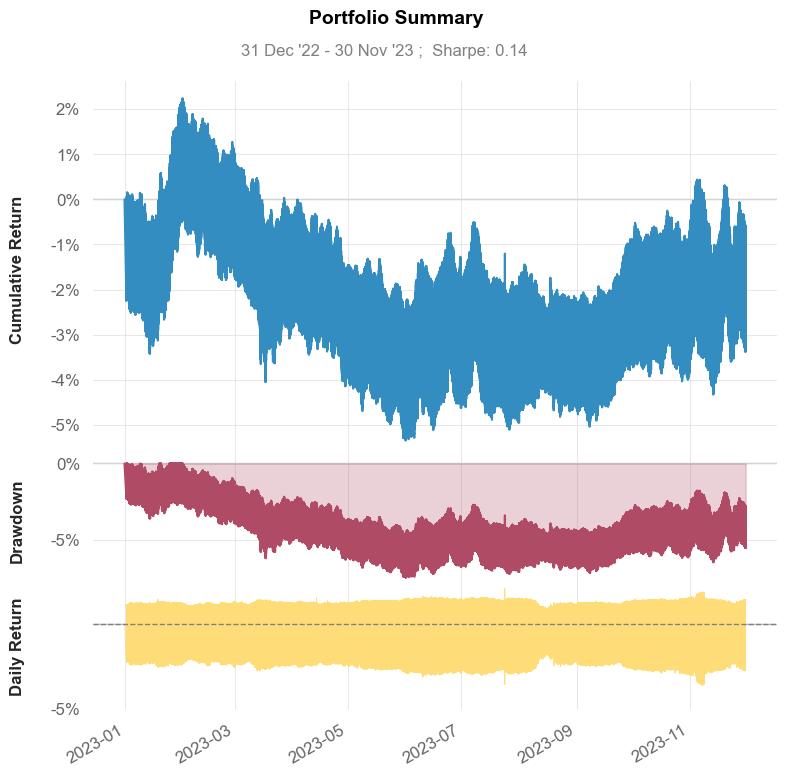

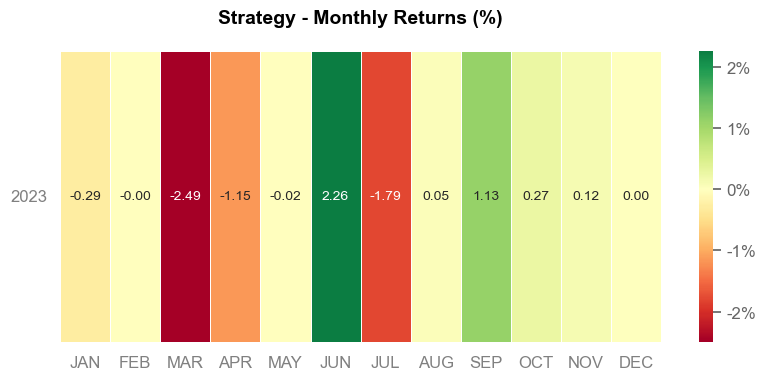

In [6]:
# best_return_daily = best_return['returns'].resample('1d').apply(lambda x: np.prod(1 + x) - 1)
qs.reports.basic(best_return['returns'])